# Segundo Sprint

Analisis de tweets:

https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit?resourcekey=0-betyQkEmWZgp8z0DFxWsHw



In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------- -------------------------- 4.5/12.8 MB 54.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 43.7 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [35]:
#Importamos librerias de interes (no hace falta utilizar todas)
import pandas as pd
import pickle
import spacy
import numpy as np
import os
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #Muy util en sentimiento
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nlp = spacy.load("en_core_web_sm")


#CONSIGNAS:

El analisis es libre, no tiene limites y se pueden agregar todas las ideas que les surjan, pueden incluir analogias, analisis de sensibilidad, keywords, modelos pre-entrenados, etc... Deben usar al menos una de las distintas metricas que vimos tales como similitud coseno, PMI, etc.

Como sugerencia, ambos archivos estan orientados a un analisis de sentimiento por lo que si optan por este caso, pueden usar ambos para ver que tan bien predice su modelo. Les paso la descripcion de cada atributo:

0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query (lyx). If there is no query, then this value is NO_QUERY.
4 - the user that tweeted (robotickilldozr)
5 - the text of the tweet (Lyx is cool)

(Opcional): Se pueden utilizar graficos (umap, wordclouds) y cualquiera de los algoritmos vistos.

### Entrega

**Fecha limite**: 9/12/2025


La presentación puede ser desde la misma notebook, pero se pueden utilizar distintas herramientas de visualizacion. La idea es que la presentacion incluya los resultados obtenidos, que decisiones se tomaron y conclusiones. No es necesario explicar el codigo, con mostrar los outputs de cada bloque es suficiente.




### Análisis de sentimiento en Twitter (Diplomatura IA)

**Autora:** Agostina Correa  
**Materia / Módulo:** Diplmatura en Inteligencia Artificial - Trabajo Práctico 3  

#### Carga del dataset
 
Las columnas son:

0. Polarity (0 = negativo, 2 = neutro, 4 = positivo)  
1. ID del tweet  
2. Fecha  
3. Query (si no hay, vale `NO_QUERY`)  
4. Usuario  
5. Texto del tweet


In [ ]:
#Voy a verificar los dos achivos para ver cual me conviene usar

#file_path = "./trainingandtestdata/testdata.manual.2009.06.14.csv"
file_path = "./trainingandtestdata/training.1600000.processed.noemoticon.csv"

cols = ["polarity", "tweet_id", "date", "query", "user", "text"]
df = pd.read_csv(
    file_path,
    encoding="latin-1",
    names=cols
)

df.head()



,polarity,tweet_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print("Shape del dataset:", df.shape)
print("\nInfo:")
df.info()

print("\nValores únicos de polarity:")
print(df["polarity"].value_counts())


Shape del dataset: (1600000, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   tweet_id  1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

Valores únicos de polarity:
polarity
0    800000
4    800000
Name: count, dtype: int64


In [5]:
#Creo otra columna llamada sentiment con etiquetas más legibles

label_map = {0: "negative", 2: "neutral", 4: "positive"}
df["sentiment"] = df["polarity"].map(label_map)

df[["polarity", "sentiment"]].head()


,polarity,sentiment
0,0,negative
1,0,negative
2,0,negative
3,0,negative
4,0,negative


In [6]:
df.isna().sum()

polarity     0
tweet_id     0
date         0
query        0
user         0
text         0
sentiment    0
dtype: int64

In [7]:
df.user.nunique() #Mas de la mitad de los usuarios son repetidos, eso puede sesgar el modelo

659775

In [8]:
df = df.drop(columns=['user','query','date','tweet_id']) 

In [9]:
df.head()

,polarity,text,sentiment
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,0,is upset that he can't update his Facebook by ...,negative
2,0,@Kenichan I dived many times for the ball. Man...,negative
3,0,my whole body feels itchy and like its on fire,negative
4,0,"@nationwideclass no, it's not behaving at all....",negative


In [10]:
df.sentiment.unique()

array(['negative', 'positive'], dtype=object)

#### Preprocesamiento


In [11]:
df = df[['text', 'sentiment']]

In [12]:
df.head(4)

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,is upset that he can't update his Facebook by ...,negative
2,@Kenichan I dived many times for the ball. Man...,negative
3,my whole body feels itchy and like its on fire,negative


In [13]:
X = df['text']  
y = df['sentiment'] 

In [14]:
y.value_counts()

sentiment
negative    800000
positive    800000
Name: count, dtype: int64

In [15]:
y.value_counts(normalize=True)*100

sentiment
negative    50.0
positive    50.0
Name: proportion, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
def limpieza_rapida(text: str) -> str:
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#Hago otra funcion porque tarda mucho en procesar todo el dataset, para pruebas uso limpieza_rapida pero para el modelo final uso esta
def limpieza_spacy(text: str) -> str:
    text = limpieza_rapida(text)
    doc = nlp(text)
    texto_limpio = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return texto_limpio

In [18]:
def sentyment_textblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [19]:
X_train = X_train.apply(limpieza_spacy)
X_test = X_test.apply(limpieza_spacy)

In [20]:
#No es necesario dividir en train y test porque no entrenamos ningun modelo pero es una buena practica
y_train_pred = X_train.apply(sentyment_textblob).apply(pd.Series)
y_test_pred = X_test.apply(sentyment_textblob).apply(pd.Series)

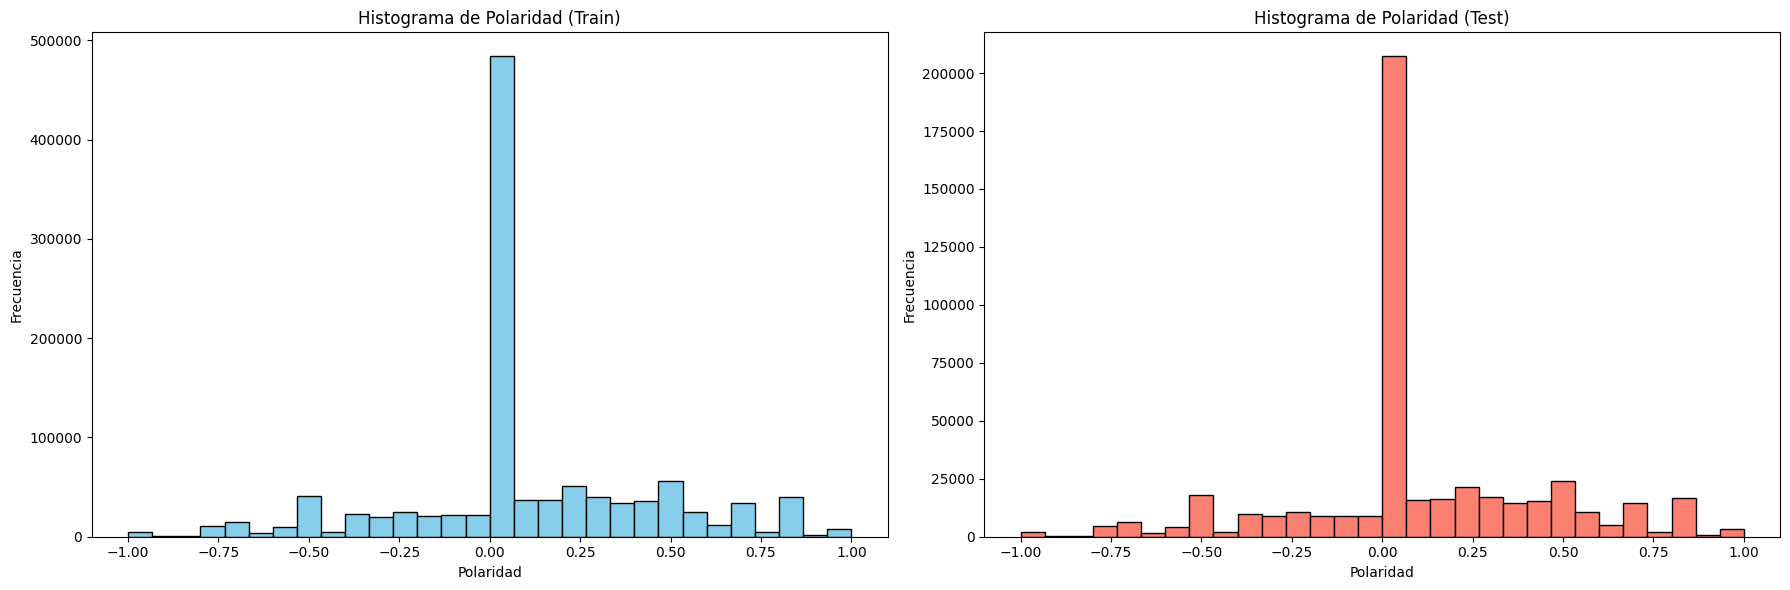

In [21]:
#Train
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(y_train_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Polaridad (Train)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

#Test
plt.subplot(1, 2, 2)
plt.hist(y_test_pred, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Polaridad (Test)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### Análisis exploratorio (EDA)

En esta sección se exploran:

- Distribución de clases.
- Longitud de los tweets.
- Palabras frecuentes por tipo


sentiment
negative    800000
positive    800000
Name: count, dtype: int64


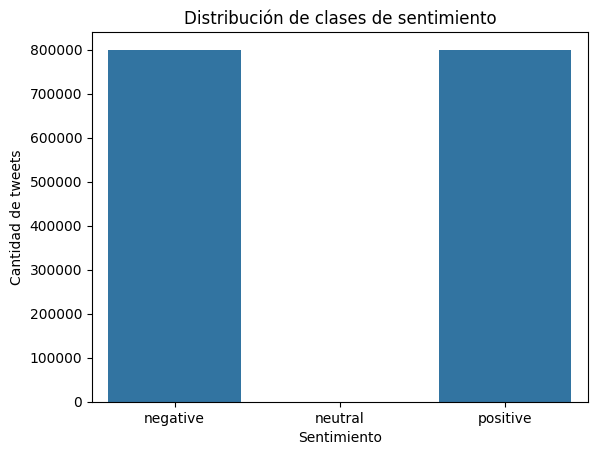

In [22]:
sent_counts = df["sentiment"].value_counts().sort_index()

print(sent_counts)

sns.countplot(x="sentiment", data=df, order=["negative", "neutral", "positive"])
plt.title("Distribución de clases de sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de tweets")
plt.show()


In [23]:
#Verifico longitud de los tweets
df["tokens"] = df["text"].str.split()

In [24]:
df.head()

,text,sentiment,tokens
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"[@switchfoot, http://twitpic.com/2y1zl, -, Aww..."
1,is upset that he can't update his Facebook by ...,negative,"[is, upset, that, he, can't, update, his, Face..."
2,@Kenichan I dived many times for the ball. Man...,negative,"[@Kenichan, I, dived, many, times, for, the, b..."
3,my whole body feels itchy and like its on fire,negative,"[my, whole, body, feels, itchy, and, like, its..."
4,"@nationwideclass no, it's not behaving at all....",negative,"[@nationwideclass, no,, it's, not, behaving, a..."


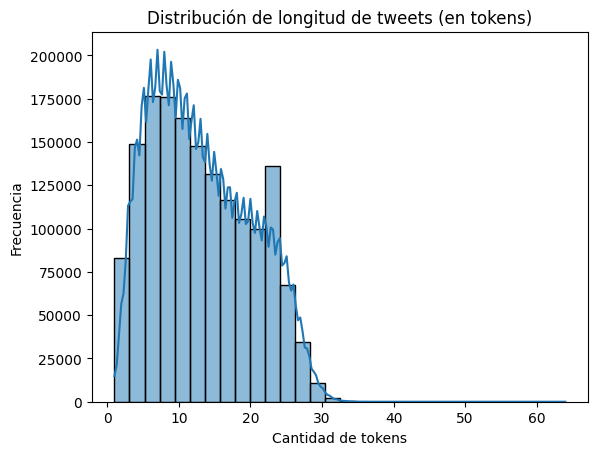

In [25]:
df["tweet_length"] = df["tokens"].apply(len)

df["tweet_length"].describe()
sns.histplot(df["tweet_length"], bins=30, kde=True)
plt.title("Distribución de longitud de tweets (en tokens)")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frecuencia")
plt.show()


#Se calculó la longitud de cada tweet en cantidad de tokens a partir del texto preprocesado y se graficó su distribución. 
#La mayoría de los tweets se concentra aproximadamente entre 5 y 20 tokens y muy pocos ejemplos 
#por encima de 30 palabras. Esto confirma que, como es esperable en Twitter, los tweets son cortos, 
# esto favorece el uso de modelos basados en bolsas de palabras (TF-IDF) ya que los textos tienen longitud corta y acotada.


In [26]:
#Ahora con el sigueinte codigo puedo cheqear para cada clase de sentimiento, 
# cuáles son las palabras más frecuentes

from collections import Counter

counters = {
    "negative": Counter(),
    "neutral": Counter(),
    "positive": Counter()
}


for sentiment, tokens in zip(df["sentiment"], df["tokens"]):
    counters[sentiment].update(tokens)


for s in ["negative", "neutral", "positive"]:
    print(f"\nTop palabras para la clase: {s}")
    print(counters[s].most_common(20))




Top palabras para la clase: negative
[('to', 306518), ('I', 299822), ('the', 241000), ('a', 175824), ('my', 166917), ('i', 160132), ('and', 140240), ('is', 118126), ('in', 108421), ('for', 96298), ('it', 91087), ('of', 90914), ('have', 77876), ('on', 77565), ('you', 75488), ('so', 72738), ('me', 69347), ('but', 68267), ('that', 61908), ('not', 61387)]

Top palabras para la clase: neutral
[]

Top palabras para la clase: positive
[('the', 246501), ('to', 246444), ('I', 196797), ('a', 190388), ('you', 138383), ('and', 135023), ('for', 113503), ('my', 113108), ('is', 99567), ('in', 93873), ('i', 89884), ('of', 88640), ('it', 80725), ('on', 76800), ('with', 62629), ('that', 56777), ('have', 54373), ('me', 53162), ('so', 52417), ('be', 51431)]


### 4. Métrica 1: PMI (Pointwise Mutual Information)

La **PMI** entre dos palanras mide qué tan asociadas están.

Valores altos del PMI indican que la palabra está **fuertemente asociada** a esa clase.


In [27]:
N = len(df)

# Conteos por clase
count_c = df["sentiment"].value_counts().to_dict()
P_c = {c: count_c[c] / N for c in count_c}

# Estructuras para conteos por palabra
word_docs = defaultdict(set)                      # palabra -> set(indices donde aparece)
word_class_docs = defaultdict(lambda: defaultdict(set))  # palabra -> clase -> set(indices)

for i, row in df.iterrows():
    tokens = set(row["tokens"])  # set para evitar duplicados dentro del mismo tweet
    c = row["sentiment"]
    for w in tokens:
        word_docs[w].add(i)
        word_class_docs[w][c].add(i)

import math

pmi_values = []

for w, docs in word_docs.items():
    Pw = len(docs) / N
    for c in count_c.keys():
        joint = len(word_class_docs[w][c])
        if joint == 0:
            continue
        Pwc = joint / N
        val = math.log2(Pwc / (Pw * P_c[c]))
        pmi_values.append((w, c, val))

pmi_df = pd.DataFrame(pmi_values, columns=["word", "class", "pmi"])

pmi_df.head()


,word,class,pmi
0,"Awww,",negative,0.156228
1,"Awww,",positive,-0.175223
2,do,negative,0.107778
3,do,positive,-0.116484
4,it.,negative,0.001510


In [28]:
def top_pmi_words(pmi_df, cls, min_docs=5, top_n=20):
    """
    Filtra palabras con al menos min_docs tweets y devuelve top_n por PMI.
    """
    temp = pmi_df[pmi_df["class"] == cls].copy()
    
    # Filtrar por mínimo soporte (opcional)
    temp["doc_count"] = temp["word"].apply(lambda w: len(word_docs[w]))
    temp = temp[temp["doc_count"] >= min_docs]
    
    temp = temp.sort_values("pmi", ascending=False).head(top_n)
    return temp

top_pmi_pos = top_pmi_words(pmi_df, "positive", min_docs=5, top_n=20)
top_pmi_neg = top_pmi_words(pmi_df, "negative", min_docs=5, top_n=20)
top_pmi_neu = top_pmi_words(pmi_df, "neutral",  min_docs=5, top_n=20)

top_pmi_pos


,word,class,pmi,doc_count
1500872,@char_x3,positive,1.0,6
1587629,Koenigsegg,positive,1.0,5
1590667,Crazyy!!,positive,1.0,6
1556864,http://bit.ly/ec8qJ,positive,1.0,6
1557465,http://FreeTheaters.com.,positive,1.0,8
1557469,http://FreeTheaters.com..,positive,1.0,10
1564891,#nomaintenance,positive,1.0,5
1584282,@Kaytasticc,positive,1.0,6
1531389,charts:,positive,1.0,5
1529880,Petition:,positive,1.0,5


In [29]:
print("Top PMI - Positive")
display(top_pmi_pos)

print("Top PMI - Negative")
display(top_pmi_neg)

print("Top PMI - Neutral")
display(top_pmi_neu)


Top PMI - Positive


,word,class,pmi,doc_count
1500872,@char_x3,positive,1.0,6
1587629,Koenigsegg,positive,1.0,5
1590667,Crazyy!!,positive,1.0,6
1556864,http://bit.ly/ec8qJ,positive,1.0,6
1557465,http://FreeTheaters.com.,positive,1.0,8
1557469,http://FreeTheaters.com..,positive,1.0,10
1564891,#nomaintenance,positive,1.0,5
1584282,@Kaytasticc,positive,1.0,6
1531389,charts:,positive,1.0,5
1529880,Petition:,positive,1.0,5


Top PMI - Negative


,word,class,pmi,doc_count
140810,Eve's,negative,1.0,6
984660,FARRAH,negative,1.0,5
984735,Fawcett!,negative,1.0,6
75681,@tai927,negative,1.0,9
981965,STUNT,negative,1.0,9
978217,Fawcett.,negative,1.0,33
965404,#Gilad,negative,1.0,6
964646,http://www.mininova.org/tor/2713340,negative,1.0,6
966547,you/gotten,negative,1.0,27
984934,"Angels,&quot;",negative,1.0,5


Top PMI - Neutral


,word,class,pmi,doc_count


#### 6. Modelo clásico de clasificación

Se entrena un modelo clásico de ML para predecir el sentimiento del tweet:

- Representación: TF-IDF
- Clasificador: **Logistic Regression**.
- Evaluación: train/test split con métricas de precisión, recall y F1 por clase.


In [30]:
X = df["text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [31]:
clf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(random_state=1))
])


In [32]:
clf.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [33]:
y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)

In [36]:
print("Reporte de clasificación para y_train:")
print(classification_report(y_train, y_train_pred))
print("------------------------------------------------------")
print("Reporte de clasificación para y_test:")
print(classification_report(y_test, y_test_pred))

Reporte de clasificación para y_train:
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82    640000
    positive       0.82      0.84      0.83    640000

    accuracy                           0.82   1280000
   macro avg       0.82      0.82      0.82   1280000
weighted avg       0.82      0.82      0.82   1280000

------------------------------------------------------
Reporte de clasificación para y_test:
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80    160000
    positive       0.80      0.81      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



#### 6. Modelo clásico de clasificación (BoW + Naive Bayes)

Además del modelo basado en TF-IDF + Logistic Regression, se entrenó un modelo clásico de machine learning utilizando:

- **Representación**: bolsa de palabras (*Bag of Words*, BoW) a partir de los conteos de términos en cada tweet.
- **Clasificador**: **Naive Bayes** (Multinomial), apropiado para datos discretos como conteos de palabras.
- **Evaluación**: esquema train/test split, reportando métricas de *precision*, *recall* y *F1-score* por clase, así como el desempeño global (accuracy).

Este modelo sirve como línea base simple: al utilizar únicamente los conteos de palabras y un clasificador probabilístico, permite comparar qué tanto mejora el rendimiento cuando se usan representaciones más ricas como TF-IDF y modelos discriminativos como Logistic Regression.


In [37]:
X = df['text']  
y = df['sentiment'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3,
    random_state=42, 
    stratify=y)

vectorizer = CountVectorizer()

In [38]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [39]:
model = MultinomialNB()

In [40]:
model.fit(X_train_bow, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [41]:
y_train_pred = model.predict(X_train_bow)
y_test_pred = model.predict(X_test_bow)

In [42]:
print("Reporte de clasificación para y_train:")
print(classification_report(y_train, y_train_pred))
print("------------------------------------------------------")
print("Reporte de clasificación para y_test:")
print(classification_report(y_test, y_test_pred))

Reporte de clasificación para y_train:
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84    560000
    positive       0.86      0.80      0.83    560000

    accuracy                           0.83   1120000
   macro avg       0.84      0.83      0.83   1120000
weighted avg       0.84      0.83      0.83   1120000

------------------------------------------------------
Reporte de clasificación para y_test:
              precision    recall  f1-score   support

    negative       0.76      0.82      0.79    240000
    positive       0.80      0.74      0.77    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



#### WordClouds por clase

Se generan nubes de palabras para visualizar rápidamente qué términos son más frecuentes en cada clase de sentimiento.


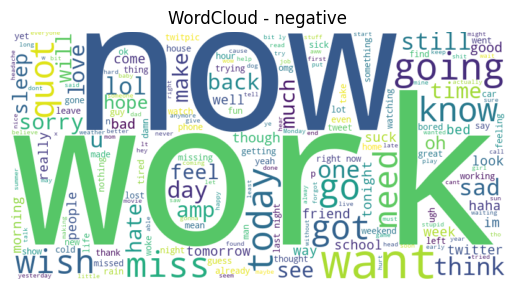

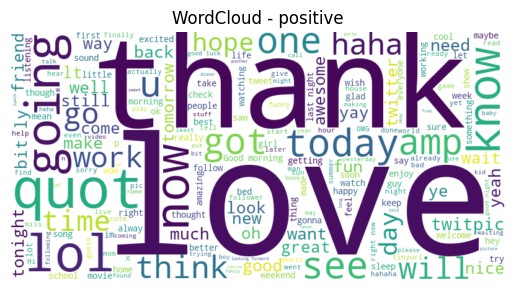

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_for_class(df, sentiment):
    text = " ".join(df.loc[df["sentiment"] == sentiment, "text"].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment}")
    plt.show()

plot_wordcloud_for_class(df, "negative")
plot_wordcloud_for_class(df, "positive")
#No uso neutral porque no aporta mucho



#### Conclusiones

En este trabajo se realizo:

- Un analisis explortorio de un dataset masivo de tweets anotados con **polaridad binaria** (`negative` / `positive`), incluyendo distribución de clases, longitud de los tweets y cantidad de usuarios.

- Un preprocesamiento básico adaptado a texto de twitter: normalización a minúsculas, eliminación de URLs, limpieza de signos de puntuación y tokenización.

- El calculo de la metrica **PMI (Pointwise Mutual Information)** para estimar la asociación entre palabras y cada clase de sentimiento.

- La construcción de nubes de palabras y listados de términos mas frecuentes por clase, para complementar el análisis cuantitativo.

- El entrenamiento de dos modelos clasicos de clasificación de sentimiento:
  - **BoW + Naive Bayes** (baseline) con accuracy = 0.78 en test.
  - **TF-IDF + Logistic Regression** (modelo principal) con accuracy = 0.80 en test.

**Observaciones principales:**

- El análisis de frecuencia y de PMI mostró que las clases `negative` y `positive` están asociadas a vocabularios claramente distintos: en tweets positivos predominan términos de elogio y aprobación, mientras que en los negativos aparecen palabras con carga negativa o de queja.

- La **longitud de los tweets** se concentra mayormente en un rango corto (aprox. 5–20 tokens), lo cual es coherente con el formato de Twitter y favorece el uso de modelos basados en bolsa de palabras (BoW/TF-IDF).

- El modelo **BoW + Naive Bayes** funciona bien como baseline sencillo, pero el modelo **TF-IDF + Logistic Regression** logra un desempeño ligeramente superior y, sobre todo, más **balanceado** entre las clases `negative` y `positive`, lo que lo hace más adecuado como modelo de referencia.

**Limitaciones:**

- Tenemos solo `negative` y `positive`, ya que el dataset no incluye ejemplos anotados como neutrales. Esto simplifica el problema, pero no captura matices intermedios.

- El dataset está compuesto por tweets antiguos (2009), con expresiones, slang y referencias temporales que pueden no reflejar el lenguaje actual.

- Los modelos utilizados (boW/TF-IDF + clasificadores lineales) no tienen en cuenta orden de palabras ni contexto más allá del documento, por lo que fenómenos como sarcasmo o dobles sentidos quedan fuera de su capacidad de representación.

Tambien, se repitieron los experimentos sobre el conjunto manual más pequeño, que sí incluye las tres clases (`negative`, `neutral`, `positive`). 

En este escenario, tanto el modelo **TF-IDF + Logistic Regression** como el modelo **BoW + Naive Bayes** obtuvieron desempeños muy similares, con un accuracy en test de aproximadamente **0.70** y **0.68** respectivamente, y un *macro F1* cercano a **0.69–0.67**. En ambos casos se observa:

- Una clara caída de rendimiento respecto del dataset masivo binario (donde el mejor modelo alcanzaba ~0.80 de accuracy).

- Una **mayor dificultad para la clase `neutral`**, que presenta los valores de F1 más bajos y concentra la mayoría de las confusiones en la matriz de confusión.

- Una diferencia marcada entre el rendimiento en train (0.97–0.98) y en test (0.68–0.70), coherente con la **poca cantidad de ejemplos** disponibles para entrenar y con la mayor complejidad de separar tres clases en lugar de dos.

Estos resultados muestra que aunque los modelos clasicos (boW/TF-IDF + clasificadores lineales) son efectivos cuando se dispone de muchos datos y un problema binario, la extensión a un esquema de tres clases sobre un conjunto pequeño requiere modelos más expresivos y mayor cantidad de datos anotados para capturar adecuadamente la neutralidad y los matices del sentimento




#### Elección del modelo para el juego interactivo

Para el juego de “Adiviná el sentimiento” se decidió utilizar el modelo basado en **TF-IDF + Logistic Regression** en lugar del modelo **BoW + Naive Bayes**.

In [45]:
import random

test_df = pd.DataFrame({
    "text": X_test,
    "true_sentiment": y_test
}).reset_index(drop=True)

user_score = 0
model_score = 0
rounds_played = 0

def jugar_una_vez():
    global user_score, model_score, rounds_played
    
    idx = random.randint(0, len(test_df) - 1)
    tweet_text = test_df.loc[idx, "text"]
    true_label = test_df.loc[idx, "true_sentiment"]
    
    print("\n===== NUEVA RONDA =====")
    print("Tweet:")
    print(tweet_text)
    print("\nOpciones válidas: negative / neutral / positive")
    
    user_guess = input("Tu predicción: ").strip().lower()
    
    mapping = {
        "neg": "negative",
        "pos": "positive",
        "neu": "neutral"
    }
    if user_guess in mapping:
        user_guess = mapping[user_guess]
    
    model_pred = clf.predict([tweet_text])[0]
    
    print("\n--- Resultados ---")
    print(f"Tu respuesta:        {user_guess}")
    print(f"Modelo predice:      {model_pred}")
    print(f"Etiqueta verdadera:  {true_label}")
    
    # Actualizamos marcadores
    if user_guess == true_label:
        user_score += 1
        print("Acertaste el sentimiento real!")
    else:
        print("No acertaste el sentimiento real.")
    
    if model_pred == true_label:
        model_score += 1
        print("El modelo acertó el sentimiento real.")
    else:
        print("El modelo se equivocó.")
    
    rounds_played += 1
    
    print("\n--- Marcador global ---")
    print(f"Rondas jugadas: {rounds_played}")
    print(f"Vos:            {user_score}")
    print(f"Modelo:         {model_score}")
    print("------------------------")


def jugar_varias_veces(n=3):
    for _ in range(n):
        jugar_una_vez()
        print("\n")
        

# Para jugar en el notebook:
#jugar_una_vez()
jugar_varias_veces(5)
 



===== NUEVA RONDA =====
Tweet:
laughing at ballet with everyone over a squished roach lolol 

Opciones válidas: negative / neutral / positive

--- Resultados ---
Tu respuesta:        positive
Modelo predice:      positive
Etiqueta verdadera:  positive
Acertaste el sentimiento real!
El modelo acertó el sentimiento real.

--- Marcador global ---
Rondas jugadas: 1
Vos:            1
Modelo:         1
------------------------



===== NUEVA RONDA =====
Tweet:
@thecamerokid~Oh now you have time for me? 

Opciones válidas: negative / neutral / positive

--- Resultados ---
Tu respuesta:        negative
Modelo predice:      negative
Etiqueta verdadera:  negative
Acertaste el sentimiento real!
El modelo acertó el sentimiento real.

--- Marcador global ---
Rondas jugadas: 2
Vos:            2
Modelo:         2
------------------------



===== NUEVA RONDA =====
Tweet:
Had my first sexual Tranny experience last night, was what i expected and don't know how to feel. 

Opciones válidas: negative / n